# Book Recommender System

This python notebook shows how to build and testing a recommender system using the two types of collaborative filtering: User-Based Collaborative Filtering (UB-CF) and Item-Based Collaborative Filtering (IB-CF). Some techniques perform data exploration and cleansing on the Book-Crossing dataset that was collected by Cai-Nicolas Ziegler in a 4-week crawl (during the August/September 2004 period) from the <a href="http://www2.informatik.uni-freiburg.de/~cziegler/BX/">Book-Crossing</a> community. It contains 1.1 million ratings of 270,000 books by 90,000 users. The ratings are on a scale from 1 to 10. The data consists of three tables: ratings, books information and users information.

# EDA

In [7]:
# import necessary libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

In [2]:
sns.set(style="darkgrid")
sns.set_palette("PuBuGn_d")

In [ ]:
books = pd.read_csv('BX-Books.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

In [4]:
# explore books data
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


image URLs columns do not seem to be required and can be dropped off.

In [76]:
# drop unnecessary columns
books = books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis = 1)
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


## Cleaning Books Dataset:

In [6]:
# check data types and correct the missing entries
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [34]:
# check the unique values for yearOfPublication
print sorted(books['yearOfPublication'].unique())

[1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]


So it seems that there are some unlogical entries which are needed to be corrected before setting the data type for yearOfPublication into int.

In [8]:
books.loc[books['yearOfPublication'] == 'DK Publishing Inc']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [9]:
# edit the two recoreds
books.loc[books['ISBN'] == '078946697X', 'bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\'"
books.loc[books['ISBN'] == '078946697X', 'publisher'] = 'DK Publishing Inc'
books.loc[books['ISBN'] == '078946697X', 'bookAuthor'] = 'Michael Teitelbaum'
books.loc[books['ISBN'] == '078946697X', 'yearOfPublication'] = 2000

books.loc[books['ISBN'] == '0789466953', 'bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\'"
books.loc[books['ISBN'] == '0789466953', 'publisher'] = 'DK Publishing Inc'
books.loc[books['ISBN'] == '0789466953', 'bookAuthor'] = 'James Buckley'
books.loc[books['ISBN'] == '0789466953', 'yearOfPublication'] = 2000

In [10]:
books.loc[books['yearOfPublication'] == 'Gallimard']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [11]:
books.loc[books['ISBN'] == '2070426769', 'bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers\'"
books.loc[books['ISBN'] == '2070426769', 'publisher'] = 'Gallimard'
books.loc[books['ISBN'] == '2070426769', 'bookAuthor'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books['ISBN'] == '2070426769', 'yearOfPublication'] = 2003

In [12]:
# convert string values into numeric values
books['yearOfPublication'] = pd.to_numeric(books['yearOfPublication'], errors = 'coerce')

In [13]:
# check again
print sorted(books['yearOfPublication'].unique())

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


It can now be seen that yearOfPublication is ranging from 0–2050 while this dataset was built in 2004, so any year after 2004 is invalid and will be replaced with mean value of remaining years.

In [14]:
books.loc[(books['yearOfPublication'] > 2004) | (books['yearOfPublication'] == 0), 'yearOfPublication'] = np.nan

In [15]:
# replace NaN values with mean value
books['yearOfPublication'] = books['yearOfPublication'].fillna(round(books['yearOfPublication'].mean()))
books['yearOfPublication'] = books['yearOfPublication'].astype(np.int32)

In [16]:
# check for NaN values
books.isnull().any()

ISBN                 False
bookTitle            False
bookAuthor            True
yearOfPublication    False
publisher             True
dtype: bool

In [17]:
# show publisher NaN values
books.loc[books['publisher'].isnull()]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [18]:
# replace NaNs with 'other'
books.loc[books['ISBN'] == '193169656X', 'publisher'] = 'Other'
books.loc[books['ISBN'] == '1931696993', 'publisher'] = 'Other'

In [19]:
# show bookAuthor NaN values
books.loc[books['bookAuthor'].isnull()]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [20]:
# handle NaN value
books.loc[books['ISBN'] == '9627982032', 'bookAuthor'] = 'International Edition'

## Cleaning Users Dataset:

In [21]:
# explore users data
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [52]:
# check types
users.dtypes

userID       int64
Location    object
Age          int32
dtype: object

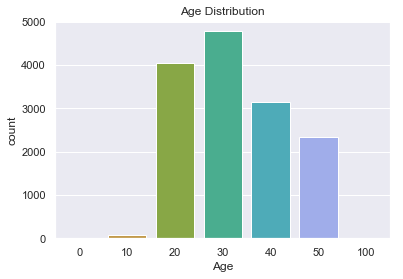

In [53]:
# check ages distribution
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
sns.countplot(data = users, x = 'Age', order=[0, 10, 20, 30, 40, 50, 100])

In [23]:
# check ages
print sorted(users['Age'].unique())

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

It's obvious that there is inconsistency in the range of Age, there are several values that are unaccepted (unreasonably high or too low), ages below 5 and above 90 can be replaced with an average age for users.

In [24]:
# remove unaccepted values
users.loc[(users['Age'] < 5) | (users['Age'] > 90), 'Age'] = np.nan

In [25]:
# replace all nan values with mean
users['Age'] = users['Age'].fillna(users['Age'].mean())
users['Age'] = users['Age'].astype(np.int32)

In [26]:
# check again
print sorted(users['Age'].unique())

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## Cleaning Ratings Dataset:

In [27]:
# explore the date
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [28]:
# check shape
ratings.shape

(1149780, 3)

it's supposed that ratings dataset provides a list of ratings that users have given to books, which means ratings should have userID and ISBN which exist in respective tables: users and books.

In [29]:
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]
ratings = ratings[ratings['userID'].isin(users['userID'])]

In [30]:
# check again
ratings.shape

(1031139, 3)

Now it's clear that users have rated some books that don't exist in the original books dataset.

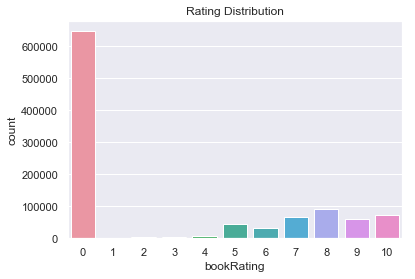

In [31]:
# check ratings distribution
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
sns.countplot(data = ratings, x = 'bookRating')

Above graph shows that most of books weren't rated (designated with 0 value) and very few ratings as 1 or 2, or 3. So all zero ratings will be ignored and only ratings represented by 1–10 can be considered.

In [4]:
# remove 0 ratings
ratings = ratings[ratings['bookRating'] != 0]

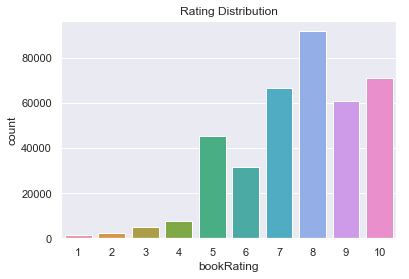

In [33]:
# check again
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
sns.countplot(data = ratings, x = 'bookRating')

# Recommender Systems

This section shows different types of book recommendation engines such as recommend the most popular books and collaborative filtering algorithms.

## Basic Popularity Model:

This model is simply based on recommends the most popular books which are rated by most number of users (highest rating counts).

In [74]:
# show most popular books based on rating counts
popular_books = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
top10 = popular_books.sort_values('bookRating', ascending = False).head(10)
top10

,bookRating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0679781587,333
0060928336,320
059035342X,313
0142001740,307
0446672211,295


It's obviuos that book with ISBN "0316666343" is the most popular book as it received highest rating counts. Let's find out what book it is and what books are these top 10..

In [77]:
top10.merge(books, left_index = True, right_on = 'ISBN')

,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,707,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
26,581,0971880107,Wild Animus,Rich Shapero,2004,Too Far
748,487,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,383,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
1105,320,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
2143,313,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,307,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
706,295,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
305,281,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company


It's clear that J.K. Rowling books are quite popular. Now we need to find out the average rating and the number of ratings each book received.

In [21]:
ave = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
ave['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
ave.sort_values('ratingCount', ascending = False).merge(books, left_index = True, on = 'ISBN').head(10)

,ISBN,bookRating,ratingCount,bookTitle,bookAuthor,yearOfPublication,publisher
408,0316666343,8.185290,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
26,0971880107,4.390706,581,Wild Animus,Rich Shapero,2004,Too Far
748,0385504209,8.435318,487,The Da Vinci Code,Dan Brown,2003,Doubleday
522,0312195516,8.182768,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
1105,0060928336,7.887500,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
2143,059035342X,8.939297,313,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,0142001740,8.452769,307,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
706,0446672211,8.142373,295,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
305,044023722X,7.338078,281,A Painted House,John Grisham,2001,Dell Publishing Company
231,0452282152,7.982014,278,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books


So it's obvious that the number of users who rated for "The Secret Life of Bees" are more the ones who rated for "Where the Heart Is "Oprah's Book Club (Paperback)", yet the average  rating for "Oprah's Book Club (Paperback)" is higher that the average rating for "The Secret Life of Bees". This is a major drawback of the systems that recommend based on the most popular items.

__<font color='green'>From above script it can be concluded that the book that received the most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.</font>__

# Collaborative Filtering based Recommendation System:

Basic idea of this algorithm is that: If a person A likes book 1, 2, 3 and B like 2, 3, 4 then they have similar interests and A should like book 4 and B should like book 1, etc. This algorithm has two types the first is __User-Based Collaborative filtering__ where we find look alike users (based on similarity) and offer books which first user's look alike has chosen in past. The second type is __Item-Based Collaborative filtering__ which is quite similar to previous algorithm, but instead of finding user look alike, we try finding book look alike. Once we have book look alike matrix, we can easily recommend alike books to user who have read any similar book.

First, to ensure statistical significance, only users who have rated at least 150 books and books which have at least 100 ratings are considered.

In [7]:
# users with more than 150 ratings
users_count = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(users_count[users_count >= 150].index)]

# books with more than 100 ratings
ratings_count = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(ratings_count[ratings_count >= 100].index)]

Next step is to generate user-book ratings matrix from the ratings dataset.

In [8]:
# generate rating matrix from ratings table
rat_mat = ratings.pivot(index='userID', columns='ISBN').bookRating
userID = rat_mat.index
ISBN = rat_mat.columns
rat_mat.head(10)

ISBN,0*708880258,0.330241664,0000000000,00000000000,0000000000000,0000000029841,0000000051,0000018030,0000722105029,0000913154,...,O439060737,O446611638,O590418262,O67174142X,O9088446X,UNGRANDHOMMED,X000000000,ZR903CX0003,"\0432534220\""""","\2842053052\"""""
userID,,,,,,,,,,,,,,,,,,,,,
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The sparsity of the matrix (NaN values) indicates that not every user rated every book.

In [9]:
# replace NaN values with 0s so they can be handled by the model
rat_mat.fillna(0, inplace = True)
# set the data type
rat_mat = rat_mat.astype(np.int32)
rat_mat.head(10)

ISBN,0*708880258,0.330241664,0000000000,00000000000,0000000000000,0000000029841,0000000051,0000018030,0000722105029,0000913154,...,O439060737,O446611638,O590418262,O67174142X,O9088446X,UNGRANDHOMMED,X000000000,ZR903CX0003,"\0432534220\""""","\2842053052\"""""
userID,,,,,,,,,,,,,,,,,,,,,
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Training The Model:

In [10]:
# set global variables
global metric, k
k = 10
metric = 'cosine'

### User-Based Collaborative Filtering (UB-CF):

The similarity_function_ub function returns the closest neighbor's similarity and index to the target user. Based on the user's recommendation system method. The prediction of predict_rating_ub function is calculated by the weighted average of the deviations of the neighbour mean values and added to the average score of the target user. Deviations are used to adjust user-related deviations. The reason for user bias is that some users may always give high or low ratings to all books.

In [11]:
# this function finds the K-nearest neighbors (KNN) to the given user based on user_id and ratings matrix
def similarity_function_ub(user_id, ratings, metric = metric, k = k):
    similarities = []
    indices = []
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k + 1)
    similarities = 1 - distances.flatten()
    return similarities, indices

In [21]:
# this function predicts the rating that the user will give to all books the k neighbors have consumed
# but this given user has not
def predict_rating_ub(user_id, book_id, ratings, metric = metric, k = k):
    prediction = weighted_sum = 0
    user_loc = ratings.index.get_loc(user_id)
    book_loc = ratings.columns.get_loc(book_id)
    similarities, indices = similarity_function_ub(user_id, ratings, metric, k)
    mean_rating = ratings.iloc[user_loc,:].mean()
    weight = np.sum(similarities) - 1
    product = 1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else:
            ratings_diff =  ratings.iloc[indices.flatten()[i], book_loc] - np.mean(ratings.iloc[indices.flatten()[i], :])
            product = ratings_diff * (similarities[i])
            weighted_sum = weighted_sum + product    
    if prediction <= 0:
        prediction = 1
    elif prediction > 10:
        prediction = 10
    prediction = int(round(mean_rating + (weighted_sum / weight)))
    print '\nPredicted rating for user {0} -> book {1}: {2}'.format(user_id, book_id, prediction)
    return prediction

In [22]:
predict_rating_ub(11676, '0001056107', rat_mat);


Predicted rating for user 11676 -> book 0001056107: 2


### Item-Based Collaborative Filtering (IB-CF):

In this approach, a cosine similarity measure is used to calculate the similarity between a pair of books. The target user can be predicted by using a simple weighted average, where function similarity_function_ib uses the nearest neighbor method to find the most similar book i of k items using cosine similarity. The function predict_rating_ib further predicts that the target user will give the rating of these specific books using this method (the below formula).

In [23]:
# this function finds similarities based on item-based collaborative filtering (IB-CF)
def similarity_function_ib(book_id, ratings, metric = metric, k = k):
    similarities = []
    indices = []
    ratings = ratings.T
    loc = ratings.index.get_loc(book_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k + 1)
    similarities = 1 - distances.flatten()
    return similarities, indices

In [24]:
similarities, indices = similarity_function_ib('0001056107', rat_mat)

In [25]:
def predict_rating_ib(user_id, book_id, ratings, metric = metric, k = k):
    prediction = weighted_sum = 0
    user_loc = ratings.index.get_loc(user_id)
    book_loc = ratings.columns.get_loc(book_id)
    similarities, indices = similarity_function_ib(book_id, ratings) #similar users based on correlation coefficients
    weight = np.sum(similarities) - 1
    product = 1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == book_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            weighted_sum = weighted_sum + product                              
    prediction = int(round(weighted_sum / weight))
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    print '\nPredicted rating for user {0} -> book {1}: {2}'.format(user_id, book_id, prediction)
    return prediction

In [26]:
prediction = predict_rating_ib(11676, '0001056107', rat_mat);


Predicted rating for user 11676 -> book 0001056107: 1


### Evaluation the Recommender System:

In [18]:
# show valid user ids
print "Select any user_id from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(rat_mat.index.values)))

Select any user_id from this list :

   2276   3757   4017   4385   6242   6251   6543   6575   7346   8890
  11676  12982  13552  16634  16795  17950  21014  23768  23872  23902
  25409  25981  26535  28591  28634  30276  30511  30711  30735  31315
  31556  31826  35433  35859  36606  37712  37950  38023  38273  39281
  39467  43246  46398  49144  51883  52199  52584  52917  55187  55490
  56271  56399  56447  56959  59172  60244  60337  60707  63714  68555
  69078  69697  70415  70594  75591  76151  76499  76626  78553  78973
  79441  81560  83671  85526  87141  88677  88693  88733  89602  89891
  93047  94242  94347  94853  95359  95902  96448  97874  98391 100906
 101209 101606 101851 102359 102702 104636 105517 107784 107951 109574
 110483 110934 110973 112001 114368 114865 114988 115003 116599 120565
 122429 123883 125774 127359 128835 129074 129716 130554 131402 135149
 135265 136010 137190 140358 142524 143175 146348 147847 148199 148258
 149907 149908 153662 156150 156269 1564

In [19]:
# this function recommends books using user-based approach (cosine/correlation)
def recommend_book_ub(user_id, ratings, metric = metric):
    preds = []
    for i in range(ratings.shape[1]):
        if (ratings[str(ratings.columns[i])][user_id] != 0):
            preds.append(predict_rating_ub(user_id, str(ratings.columns[i]), ratings, metric))
        else:
            preds.append(-1)

    preds = pd.Series(preds)
    preds = preds.sort_values(ascending = False)
    recommended = preds[:10]
    for i in range(len(recommended)):
        print "{0}. {1}".format( i + 1, books.bookTitle[recommended.index[i]].encode('utf-8'))

In [22]:
recommend_book_ub(274301, rat_mat, 'cosine')

1. The Perfect Mother
2. Trust No One (Silhouette Intimate Moments, 1248)
3. Memoiren einer Tochter aus gutem Hause.
4. Other People's Children
5. The Boy Who Cried Wolf (Pied Piper Paperbacks)
6. A Tale of Two Cities
7. All Shook Up (Avon Romance)
8. Amigo
9. Was ich liebte.
10. 11 Edward Street


In [23]:
recommend_book_ub(274301, rat_mat, 'correlation')

1. Other People's Children
2. Memoiren einer Tochter aus gutem Hause.
3. The Perfect Mother
4. Trust No One (Silhouette Intimate Moments, 1248)
5. A Tale of Two Cities
6. Was ich liebte.
7. Becoming a Woman of Excellence
8. All Shook Up (Avon Romance)
9. Amigo
10. The Boy Who Cried Wolf (Pied Piper Paperbacks)


In [28]:
# this function recommends books using item-based approach (cosine/correlation)
def recommend_book_ib(user_id, ratings, metric = metric):
    preds = []
    for i in range(ratings.shape[1]):
        if (ratings[str(ratings.columns[i])][user_id] != 0):
            preds.append(predict_rating_ib(user_id, str(ratings.columns[i]), ratings, metric))
        else:
            preds.append(-1)

    preds = pd.Series(preds)
    preds = preds.sort_values(ascending = False)
    recommended = preds[:10]
    for i in range(len(recommended)):
        print "{0}. {1}".format( i + 1, books.bookTitle[recommended.index[i]].encode('utf-8'))

In [29]:
recommend_book_ib(274301, rat_mat, 'cosine')

1. Do Not Disturb (Avon Romance)
2. Der Keltische Ring.
3. A Christmas Carol (Puffin Classics (Paperback))
4. The Secret at the Polk Street School (Kids of the Polk Street School)
5. Wainewright the Poisoner
6. Digital Rush: Nine Internet Start-Ups in the Race for Dot.Com Riches
7. The Big Book of American Trivia (Big Book of Series)
8. Washington's Dirigible (Timeline Wars/John Barnes, No 2)
9. N Is for Noose
10. MAN WHO OWN VERMNT


In [30]:
recommend_book_ib(274301, rat_mat, 'correlation')

1. Do Not Disturb (Avon Romance)
2. Der Keltische Ring.
3. A Christmas Carol (Puffin Classics (Paperback))
4. The Secret at the Polk Street School (Kids of the Polk Street School)
5. Wainewright the Poisoner
6. Digital Rush: Nine Internet Start-Ups in the Race for Dot.Com Riches
7. The Big Book of American Trivia (Big Book of Series)
8. Washington's Dirigible (Timeline Wars/John Barnes, No 2)
9. N Is for Noose
10. MAN WHO OWN VERMNT
